In [235]:
from fastai.text import *
import html
import json

In [236]:
BOS = 'xbos'  # beginning-of-sentence tag
FLD = 'xfld'  # data field tag

DATA_PATH=Path('data_spanish')

OUTPUT_PATH=Path('output')

WIKILM_PATH=OUTPUT_PATH/'wiki_lm'

TASSLM_PATH=OUTPUT_PATH/'sansetass_lm'
TASSLM_PATH.mkdir(exist_ok=True)

CLAS_PATH=OUTPUT_PATH/'sansetass_clas'
CLAS_PATH.mkdir(exist_ok=True)

In [237]:
%%javascript
// Original source -- https://gist.github.com/xem/670dec8e70815842eb95
Jupyter.beep = () => {
    var A=new AudioContext();
    var o = A.createOscillator();
    o.connect(A.destination);
    o.start(0);
    var duration = 500;
    setTimeout(function(){o.stop(); A.close();}, duration);
}

<IPython.core.display.Javascript object>

## Pre-Process TASS Dataset

Load dataset

In [238]:
TASS_DATA_PATH = Path(DATA_PATH/'sanseTASS/task_4_subtask1_train_dev/')
TRN_PATH = TASS_DATA_PATH/'trn'
VAL_PATH = TASS_DATA_PATH/'dev'

BOS = 'xbos'  # beginning-of-sentence tag
FLD = 'xfld'  # data field tag

In [239]:
def get_dataset(dataset):
    headers = []
    ids = []
    countries = []
    urls = []
    headlines = []
    dates = []
    tags = []
    with open(dataset,'r', encoding='utf8') as file:
        file = csv.reader(file, delimiter='\t')
        loop = 0
        for row in file:
            if loop>0:
                ids.append(row[0])
                countries.append(row[1])
                urls.append(row[2])
                headlines.append(row[3])
                dates.append(row[4])
                tags.append(row[5])
            else:
                headers.append(row[0], row[1], row[2], row[3], row[4], row[5])s
            loop+=1
    return headers, ids, countries, urls, headlines, dates, tags

In [240]:
trn_headers, trn_ids, trn_countries, trn_urls, trn_headlines, trn_dates, trn_tags = get_dataset(TRN_PATH/'SANSE_train-1.tsv')

In [241]:
val_headers, val_ids, val_countries, val_urls, val_headlines, val_dates, val_tags = get_dataset(VAL_PATH/'SANSE_dev-1.tsv')

Check how big our dataset is

In [242]:
print(len(trn_ids))
print(len(val_ids))

1250
250


Labels to integers

In [247]:
def labels_to_num(tags, labels_dict):
    labels = [labels_dict[i] for i in tags]
    labels = np.array(labels)
    return labels


str_labels = set(trn_tags)
labels_dict = {tag: i for i, tag in enumerate(trn_str_labels)}

trn_labels = labels_to_num(trn_tags, labels_dict)
val_labels = labels_to_num(val_tags, labels_dict)

Some standard pre-processing: We delete all None type tweets, we replace some tokens with more meaningful ones and we shuffle tokens randomly

In [249]:
def flattern(A):
    'Source: https://stackoverflow.com/a/17867797/7273299'
    
    'Flattens a list of lists and strings into a list.'
    rt = []
    for i in A:
        if isinstance(i,list): rt.extend(flattern(i))
        else: rt.append(i)
    return rt

In [250]:
def isInt(v):
    'Source: https://stackoverflow.com/a/9859202/7273299'
    
    'Checks if a string is a number.'
    try:     i = int(v)
    except:  return False
    return True

In [251]:
def int_placeholder(headlines):
    headlines = [[[i,'int_string'] if isInt(i) else i for i in headline.split()] for headline in headlines]
    headlines = np.array([flattern(headline) for headline in headlines])
    headlines = np.array([' '.join(i) for i in headlines])
    return headlines

In [252]:
trn_heads = int_placeholder(trn_headlines)
val_heads = int_placeholder(val_headlines)

In [253]:
def cty_headlines(countries, headlines):
    # Probar con y sin
    cty_heads = []
    for i in range(len(countries)):
        cty_heads.append(str(countries[i])+' '+str(headlines[i]))
    cty_heads = np.array(cty_heads) 
    return cty_heads

In [254]:
trn_heads = cty_headlines(trn_countries, trn_heads)
val_heads = cty_headlines(val_countries, val_heads)

In [255]:
def random_order(headlines, labels):
    idx = np.random.permutation(len(headlines))
    return headlines[idx], labels[idx]

In [256]:
np.random.seed(42)

trn_heads, trn_labels = random_order(trn_heads, trn_labels)
val_heads, val_labels = random_order(val_heads, val_labels)

In [257]:
for i in range(len(val_heads)):
    print(val_heads[i], val_labels[i])

ESP José Luis Ábalos: "Rajoy tendrá que convocar elecciones si no sale de la parálisis" 1
VEN Maduro quiere enfrentarse a Ramos Allup en las elecciones presidenciales 1
USA Obispo de la diócesis de Chilpancingo-Chilapa pide dialogar con el crimen organizado 1
ESP La inteligencia de EE UU alerta del riesgo de injerencia rusa en las legislativas de noviembre y en Europa 1
ESP Las denuncias a menores por violencia machista se triplican 1
MEX Vecinos denuncia maltrato animal en supuesta pensión de la Merced Gómez 1
COL 'Ante corrupción, la Corte se autocriticó y renovó': Hernández 1
MEX Aparece con vida el periodista Mario Cañas 0
USA Se separaron Jennifer Aniston y Justin Theroux, tras dos años y medio de matrimonio 1
USA La ANMAT prohibió la comercialización de productos médicos y alimenticios 1
COL Murió el principal predicador de Estados Unidos 1
CHI Manchester City golea a Arsenal y sigue firme hacia el título de la Premier League 0
ESP Programa especial del Día de la Mujer: Paramos 0

In [258]:
col_names = ['label', 'headline']

Build validation and training sets

In [261]:
df_trn = pd.DataFrame({'headline':trn_heads, 'label':trn_labels}, columns=col_names)
df_val = pd.DataFrame({'headline':val_heads, 'label':val_labels}, columns=col_names)
(CLAS_PATH/'classes.txt').open('w').writelines(f'{o}\n' for o in str_labels)

In [262]:
df_trn.head(15)

,label,headline
0,1,CHI Obra genera polémica en día de apertura de...
1,0,ARG Los detalles del despliegue del Gobierno p...
2,0,PER Claudia Cooper: Nuevo proyecto no parará p...
3,1,COL Un soldado muerto en ataque a base militar...
4,1,PER Piura: incendio dejó un niño herido y 27 i...
5,1,PER Chorrillos: detienen a sujetos que robaban...
6,0,"ESP Las Palmas - Barcelona en directo, la Liga..."
7,1,PER Agricultores de Torata acuerdan reanudar p...
8,0,COL El técnico Miguel Ángel Russo se juega un ...
9,1,VEN EE UU acusó a China por tener responsabili...


We store the datasets in pandas dataframes for later use

In [263]:
df_trn.to_csv(CLAS_PATH/'train.csv', header=False, index=False)
df_val.to_csv(CLAS_PATH/'validation.csv', header=False, index=False)

In [264]:
df_trn = pd.DataFrame({'headline':trn_heads, 'label':[0]*len(trn_labels)}, columns=col_names)
df_val = pd.DataFrame({'headline':val_heads, 'label':[0]*len(val_labels)}, columns=col_names)

In [265]:
df_trn.to_csv(TASSLM_PATH/'train.csv', header=False, index=False)
df_val.to_csv(TASSLM_PATH/'validation.csv', header=False, index=False)

## Tokenize and Standarize General Tokens for TASS Dataset

Second Pre-processing using fast.ai functions

In [266]:
chunksize=24000

re1 = re.compile(r'  +')

In [267]:
def fixup(x):
    x = x.replace('#39;', "'").replace('amp;', '&').replace('#146;', "'").replace(
        'nbsp;', ' ').replace('#36;', '$').replace('\\n', "\n").replace('quot;', "'").replace(
        '<br />', "\n").replace('\\"', '"').replace('<unk>','u_n').replace(' @.@ ','.').replace(
        ' @-@ ','-').replace('\\', ' \\ ')
    return re1.sub(' ', html.unescape(x))

def get_texts(df, n_lbls=1):
    labels = df.iloc[:,range(n_lbls)].values.astype(np.int64)
    texts = f'\n{BOS} ' + df[n_lbls].astype(str)
    for i in range(n_lbls+1, len(df.columns)): texts += f' {FLD} {i-n_lbls} ' + df[i].astype(str)
    texts = texts.apply(fixup).values.astype(str)

    tok = Tokenizer(lang='es').proc_all_mp(partition_by_cores(texts), lang='es')
    return tok, list(labels)

def get_all(df, n_lbls):
    tok, labels = [], []
    for i, r in enumerate(df):
        tok_, labels_ = get_texts(r, n_lbls)
        tok += tok_;
        labels += labels_
    return tok, labels

In [268]:
df_trn = pd.read_csv(TASSLM_PATH/'train.csv', header=None, chunksize=chunksize)
df_val = pd.read_csv(TASSLM_PATH/'validation.csv', header=None, chunksize=chunksize)

In [269]:
tok_trn, trn_labels = get_all(df_trn, 1)
tok_val, val_labels = get_all(df_val, 1)

In [270]:
(TASSLM_PATH/'tmp').mkdir(exist_ok=True)

In [271]:
np.save(TASSLM_PATH/'tmp'/'tok_trn.npy', tok_trn)
np.save(TASSLM_PATH/'tmp'/'tok_val.npy', tok_val)

In [272]:
tok_trn = np.load(TASSLM_PATH/'tmp'/'tok_trn.npy')
tok_val = np.load(TASSLM_PATH/'tmp'/'tok_val.npy')

In [273]:
freq = Counter(p for o in tok_trn for p in o)
freq.most_common(20)

[('t_up', 1447),
 ('\n', 1250),
 ('xbos', 1250),
 ('de', 985),
 ('en', 567),
 ('la', 454),
 ('a', 437),
 ('el', 385),
 (':', 251),
 ('y', 224),
 ('esp', 207),
 ('"', 197),
 ('int_string', 193),
 ('por', 189),
 ('que', 184),
 ('del', 182),
 (',', 173),
 ('usa', 157),
 ('ven', 153),
 ('un', 151)]

In [274]:
max_vocab = 60000
min_freq = 2

In [275]:
itos = [o for o,c in freq.most_common(max_vocab) if c>min_freq]
itos.insert(0, '_pad_')
itos.insert(0, '_unk_')

stoi = collections.defaultdict(lambda:0, {v:k for k,v in enumerate(itos)})
len(itos)

845

In [276]:
trn_lm = np.array([[stoi[o] for o in p] for p in tok_trn])
val_lm = np.array([[stoi[o] for o in p] for p in tok_val])

In [277]:
np.save(TASSLM_PATH/'tmp'/'trn_ids.npy', trn_lm)
np.save(TASSLM_PATH/'tmp'/'val_ids.npy', val_lm)
pickle.dump(itos, open(TASSLM_PATH/'tmp'/'itos.pkl', 'wb'))

In [278]:
%%javascript
Jupyter.beep();

<IPython.core.display.Javascript object>

## Build Database of all Spanish Wikipedia articles with >10000 words

In [181]:
jsons = []
for direc in DATA_PATH/'eswiki+100'.iterdir():
    print (direc)
    for file in direc.iterdir():
        print(file)
        for line in open(file, 'r', encoding="utf-8"):
            jsons.append(json.loads(line))

AttributeError: 'str' object has no attribute 'iterdir'

In [4]:
jsons[0].keys()

dict_keys(['url', 'text', 'id', 'title'])

In [5]:
ID = 'id'
TITLE = 'title'
TEXT = 'text'
URL = 'url'

In [6]:
idx = np.random.permutation(len(jsons))

Validation set will be 1% of the total dataset since the dataset is so big

In [7]:
limit_sets = int(len(jsons)*0.99)

trn_set = [jsons[i] for i in idx[:limit_sets]]
val_set = [jsons[i] for i in idx[limit_sets:]]

In [8]:
def remove_title(texts):
    return texts.split('\n\n', 1)[-1]

In [9]:
trn_ids = [exmp[ID] for exmp in trn_set]
trn_titles = [exmp[TITLE] for exmp in trn_set]
trn_texts = [remove_title(exmp[TEXT]) for exmp in trn_set]
trn_urls = [exmp[URL] for exmp in trn_set]

In [10]:
val_ids = [exmp[ID] for exmp in val_set]
val_titles = [exmp[TITLE] for exmp in val_set]
val_texts = [remove_title(exmp[TEXT]) for exmp in val_set]
val_urls = [exmp[URL] for exmp in val_set]

In [34]:
col_names = ['id','title','text','url']

In [35]:
df_trn = pd.DataFrame({'id':trn_ids, 'title':trn_titles, 'text':trn_texts, 'url':trn_urls}, columns=col_names)
df_val = pd.DataFrame({'id':val_ids, 'title':val_titles, 'text':val_texts, 'url':val_urls}, columns=col_names)

In [36]:
df_trn.head(5)

,id,title,text,url
0,6066379,Noche de Brujas (banda),Noche de Brujas es una agrupación musical chil...,https://es.wikipedia.org/wiki?curid=6066379
1,959915,Ley de Gutenberg-Richter,La ley de Gutenberg-Richter (1958) es una fórm...,https://es.wikipedia.org/wiki?curid=959915
2,5698339,La leyenda de Spyro: Un nuevo comienzo,La leyenda de Spyro: Un nuevo comienzo (en ing...,https://es.wikipedia.org/wiki?curid=5698339
3,343047,Estadio Luis II,"El Estadio Luis II (en francés: ""Stade Louis I...",https://es.wikipedia.org/wiki?curid=343047
4,366898,Blanquillo (Uruguay),Blanquillo es una localidad uruguaya del depar...,https://es.wikipedia.org/wiki?curid=366898


In [37]:
len(trn_set), len(val_set)

(389072, 97268)

In [11]:
col_names = ['title','text']

In [12]:
df_trn = pd.DataFrame({'title':trn_titles, 'text':trn_texts}, columns=col_names)
df_val = pd.DataFrame({'title':val_titles, 'text':val_texts}, columns=col_names)

In [14]:
df_trn.to_csv(WIKILM_PATH/'train+100.csv', header=False, index=False)
df_val.to_csv(WIKILM_PATH/'val+100.csv', header=False, index=False)

## Tokenize and Standarize General Tokens for Wiki Corpus

In [20]:
chunksize=4000

In [21]:
re1 = re.compile(r'  +')

def fixup(x):
    x = x.replace('#39;', "'").replace('amp;', '&').replace('#146;', "'").replace(
        'nbsp;', ' ').replace('#36;', '$').replace('\\n', "\n").replace('quot;', "'").replace(
        '<br />', "\n").replace('\\"', '"').replace('<unk>','u_n').replace(' @.@ ','.').replace(
        ' @-@ ','-').replace('\\', ' \\ ').replace('\xa0', ' ')
    return re1.sub(' ', html.unescape(x))

In [22]:
def get_texts(df, n_lbls=0):
    texts = f'\n{BOS} {FLD} 1 ' + df[n_lbls].astype(str)
    for i in range(n_lbls+1, len(df.columns)):
        texts += f' {FLD} {i-n_lbls} ' + df[i].astype(str)
    texts = texts.apply(fixup).values.astype(str)
    
    tok = Tokenizer(lang='es').proc_all_mp(partition_by_cores(texts), lang='es')
    return tok

In [23]:
def get_all(df, n_lbls):
    tok, labels = [], []
    l = 0
    for i, r in enumerate(df):
        print(i)
        l += 1
        tok_ = get_texts(r, n_lbls)
        tok += tok_;
        #if i >= 35:
            #return tok
    return tok

In [17]:
df_trn = pd.read_csv(WIKILM_PATH/'train+100.csv', header=None, chunksize=chunksize)
df_val = pd.read_csv(WIKILM_PATH/'val+100.csv', header=None, chunksize=chunksize)

In [18]:
(WIKILM_PATH/'tmp').mkdir(exist_ok=True)

In [19]:
l = 0
for i,_ in enumerate(df_trn):
    l+=1
print(l)

KeyboardInterrupt: 

In [ ]:
tok_val = get_all(df_val, 0)
np.save(WIKILM_PATH/'tmp'/'tok_val+100.npy', tok_val)

In [ ]:
from math import ceil

def chunks(l, n):
    """Yield successive n-sized chunks from l."""
    for i in range(0, len(l), n):
        yield l[i:i + n]
        
mini_chunks = chunks(tok_trn, ceil(len(tok_trn)/4))
for i, mini in enumerate(mini_chunks):
    name = 'tmp/tok_trn'+str(i)+'+100.npy'
    np.save(WIKILM_PATH/name, mini)

In [ ]:
tok_trn0 = np.load(WIKILM_PATH/'tmp'/'tok_trn0+100.npy')
tok_trn1 = np.load(WIKILM_PATH/'tmp'/'tok_trn1+100.npy')
tok_trn2 = np.load(WIKILM_PATH/'tmp'/'tok_trn2+100.npy')
tok_trn3 = np.load(WIKILM_PATH/'tmp'/'tok_trn3+100.npy')

tok_trn = np.concatenate((tok_trn0, tok_trn1, tok_trn2, tok_trn3))
# tok_trn = np.load(WIKILM_PATH/'tmp'/'tok_trn+100.npy')
tok_val = np.load(WIKILM_PATH/'tmp'/'tok_val+100.npy')

Reduce dataset size to make it easier to work with (target 120M tokens)

In [8]:
tok_trn  = tok_trn[:(len(tok_trn)*5)//8]

Check number of tokens

In [10]:
i = 0
for text in tok_trn:
    for char in text:
        i+=1
print (i)

120137944


In [9]:
np.save(WIKILM_PATH/'tmp'/'tok_trn+100.npy', tok_trn)
tok_trn = np.load(WIKILM_PATH/'tmp'/'tok_trn+100.npy')

In [12]:
freq = Counter(p for o in tok_trn for p in o)
freq.most_common(25)

[('de', 7858311),
 (',', 6244351),
 ('la', 4485493),
 ('.', 3683917),
 ('el', 3478795),
 ('en', 3442403),
 ('y', 2816731),
 ('que', 2097825),
 ('a', 2075629),
 ('"', 1786621),
 ('los', 1761963),
 ('del', 1452380),
 ('se', 1338509),
 ('\n\n', 1151707),
 ('por', 1083461),
 ('las', 1074070),
 ('un', 1010824),
 ('con', 991543),
 ('una', 875506),
 ('su', 841859),
 ('para', 677392),
 (')', 659613),
 ('(', 655545),
 ('al', 640314),
 ('como', 630415)]

In [13]:
max_vocab = 60000
min_freq = 5

In [14]:
itos2 = [o for o,c in freq.most_common(max_vocab) if c>min_freq]
itos2.insert(0, '_pad_')
itos2.insert(0, '_unk_')
stoi2 = collections.defaultdict(lambda:0, {v:k for k,v in enumerate(itos)})
len(itos2)

60002

In [15]:
trn_lm = np.array([[stoi2[o] for o in p] for p in tok_trn])
val_lm = np.array([[stoi2[o] for o in p] for p in tok_val])

In [16]:
np.save(WIKILM_PATH/'tmp'/'trn_ids+100.npy', trn_lm)
np.save(WIKILM_PATH/'tmp'/'val_ids+100.npy', val_lm)
pickle.dump(itos2, open(WIKILM_PATH/'tmp'/'itos+100.pkl', 'wb'))

## Wiki+100 Model

In [452]:
wd=1e-7
bptt=70
bs=32
em_sz,nh,nl = 400,1150,3
#opt_fn = partial(optim.Adam, betas=(0.8, 0.99))
opt_fn = partial(optim.SGD, momentum=0.9)

In [453]:
trn_lm = np.load(WIKILM_PATH/'tmp'/'trn_ids+100.npy')
val_lm = np.load(WIKILM_PATH/'tmp'/'val_ids+100.npy')
trn_lm = np.concatenate(trn_lm)
val_lm = np.concatenate(val_lm)

KeyboardInterrupt: 

In [ ]:
itos = pickle.load(open(WIKILM_PATH/'tmp'/'itos+100.pkl', 'rb'))
vs = len(itos)

trn_dl = LanguageModelLoader(trn_lm, bs, bptt)
val_dl = LanguageModelLoader(val_lm, bs, bptt)
md = LanguageModelData(WIKILM_PATH, 1, vs, trn_dl, val_dl, bs=bs, bptt=bptt)

In [ ]:
drops = np.array([0.25, 0.1, 0.2, 0.02, 0.15])*0.5

In [ ]:
learner= md.get_model(opt_fn, em_sz, nh, nl, 
    dropouti=drops[0], dropout=drops[1], wdrop=drops[2], dropoute=drops[3], dropouth=drops[4])

learner.metrics = [accuracy]
learner.unfreeze()

In [ ]:
learner.lr_find2(start_lr=1,end_lr=10, num_it=800)

In [ ]:
learner.sched.plot()

In [14]:
%%javascript
Jupyter.beep();

<IPython.core.display.Javascript object>

In [15]:
lr=2
lrs = lr

In [16]:
learner.fit(lr, 1, cycle_len=10, use_clr_beta=(10,10,0.95,0.85))

HBox(children=(IntProgress(value=0, description='Epoch', max=10), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                           
    0      4.243111   4.193037   0.257854  
    1      4.01907    3.969443   0.272689                           
    2      3.908034   3.872785   0.278616                           
    3      3.844105   3.821897   0.282531                           
    4      3.803215   3.780296   0.285598                           
    5      3.7653     3.746013   0.28916                            
    6      3.780881   3.710472   0.293218                           
    7      3.728705   3.676514   0.296869                           
    8      3.685521   3.627796   0.303029                           
    9      3.641547   3.587603   0.308747                           



[array([3.5876]), 0.3087470562991961]

In [ ]:
%%javascript
Jupyter.beep();

In [19]:
learner.save('first_run_spanish')

In [23]:
path = learner.models_path; path

'data_spanish/eswiki+100/models'

## Save Encoder and Weights

In [37]:
learner.save_encoder('lm1_enc')

NameError: name 'learner' is not defined

In [38]:
learner.save('lm1_wgts')

NameError: name 'learner' is not defined

## Load Encoder Weights for Language Model

The wiki model was run with new parameters (lr=1.4, dropout=0.4(0.25, 0.1, 0.2, 0.02, 0.15), clip=.4) and got better results (3.4 validation loss). This is the model that was loaded for the rest of the experimentation.

In [176]:
BACKBONE_MODEL = WIKILM_PATH/'models/lm1_weights_kl.h5'

In [177]:
wgts = torch.load(BACKBONE_MODEL, map_location=lambda storage, loc: storage)

We use the average weight to fill unknown tokens from the TASS language model.

In [178]:
enc_wgts = to_np(wgts['0.encoder.weight'])
row_m = enc_wgts.mean(0)

In [179]:
itos2 = pickle.load((WIKILM_PATH/'tmp'/'itos+100.pkl').open('rb'))
stoi2 = collections.defaultdict(lambda:-1, {v:k for k,v in enumerate(itos2)})

We match up vocab words and indexes to make the dimensions of the wiki model compatible with the language model.

In [180]:
em_sz,nh,nl = 400,1150,3

In [181]:
trn_lm = np.load(TASSLM_PATH/'tmp'/'trn_ids.npy')
val_lm = np.load(TASSLM_PATH/'tmp'/'val_ids.npy')
itos = pickle.load(open(TASSLM_PATH/'tmp'/'itos.pkl', 'rb'))

In [182]:
vs=len(itos)
vs,len(trn_lm)

(845, 1250)

In [183]:
new_w = np.zeros((vs, em_sz), dtype=np.float32)
for i,w in enumerate(itos):
    r = stoi2[w]
    new_w[i] = enc_wgts[r] if r>=0 else row_m

Overwrite corresponding weights for the encoder and decoder.

In [184]:
wgts['0.encoder.weight'] = T(new_w)
wgts['0.encoder_with_dropout.embed.weight'] = T(np.copy(new_w))
wgts['1.decoder.weight'] = T(np.copy(new_w))

## Language Model Finetuning

In [185]:
wd=1e-7
bptt=70
bs=64
em_sz,nh,nl = 400,1150,3
opt_fn = partial(optim.SGD, momentum=0.9)

In [186]:
trn_lm = np.load(TASSLM_PATH/'tmp'/'trn_ids.npy')
val_lm = np.load(TASSLM_PATH/'tmp'/'val_ids.npy')
trn_lm = np.concatenate(trn_lm)
val_lm = np.concatenate(val_lm)

In [187]:
itos = pickle.load(open(TASSLM_PATH/'tmp'/'itos.pkl', 'rb'))
vs = len(itos)

trn_dl = LanguageModelLoader(trn_lm, bs, bptt)
val_dl = LanguageModelLoader(val_lm, bs//4, bptt)
md = LanguageModelData(TASSLM_PATH, 1, vs, trn_dl, val_dl, bs=bs, bptt=bptt)

In [188]:
drops = np.array([0.25, 0.1, 0.2, 0.02, 0.15])*0.9

In [189]:
learn = md.get_model(opt_fn, em_sz, nh, nl, 
    dropouti=drops[0], dropout=drops[1], wdrop=drops[2], dropoute=drops[3], dropouth=drops[4])

learn.metrics = [accuracy]
learn.unfreeze()

In [190]:
learn.model.load_state_dict(wgts)

In [192]:
learn.lr_find2(start_lr=1e-1,end_lr=30, num_it=300)

HBox(children=(IntProgress(value=0, description='Epoch', max=101), HTML(value='')))

 33%|███▎      | 1/3 [00:00<00:01,  1.81it/s, loss=5.03]


KeyboardInterrupt: 

In [ ]:
learn.sched.plot()

In [193]:
lr=5
lrs = lr

In [194]:
learn.clip=0.25

In [195]:
learn.fit(lr, 1, cycle_len=35, use_clr_beta=(10,33,0.95,0.85), best_save_name='lm1_wgts')

HBox(children=(IntProgress(value=0, description='Epoch', max=35), HTML(value='')))

epoch      trn_loss   val_loss   accuracy               
    0      4.161495   3.321176   0.393786  
    1      3.954628   3.044201   0.436029               
    2      3.74515    2.857956   0.450973               
    3      3.5867     2.759296   0.443979               
    4      3.473669   2.682813   0.457101               
    5      3.363771   2.586893   0.46744                
    6      3.270744   2.5266     0.468369               
    7      3.189145   2.542507   0.458984               
    8      3.12132    2.516506   0.466518               
    9      3.058249   2.464384   0.484747               
    10     3.001654   2.452816   0.479539               
    11     2.949978   2.498177   0.464558               
    12     2.899485   2.476486   0.467028               
    13     2.85016    2.420901   0.483025               
    14     2.804472   2.418669   0.490189               
    15     2.761056   2.456817   0.477896               
    16     2.720982   2.408581   0.492006   

[array([2.42032]), 0.491392230737709]

In [196]:
learn.load('lm1_wgts')
learn.save_encoder('lm1_enc')

In [417]:
%%javascript
Jupyter.beep();

<IPython.core.display.Javascript object>

## Classifier tokens

In [279]:
chunksize=24000

re1 = re.compile(r'  +')

In [280]:
df_trn = pd.read_csv(CLAS_PATH/'train.csv', header=None, chunksize=chunksize)
df_val = pd.read_csv(CLAS_PATH/'validation.csv', header=None, chunksize=chunksize)

In [281]:
tok_trn, trn_labels = get_all(df_trn, 1)
tok_val, val_labels = get_all(df_val, 1)

In [282]:
(CLAS_PATH/'tmp').mkdir(exist_ok=True)

In [283]:
np.save(CLAS_PATH/'tmp'/'tok_trn.npy', tok_trn)
np.save(CLAS_PATH/'tmp'/'tok_val.npy', tok_val)

In [284]:
np.save(CLAS_PATH/'tmp'/'trn_labels.npy', trn_labels)
np.save(CLAS_PATH/'tmp'/'val_labels.npy', val_labels)

In [285]:
trn_labels = np.load(CLAS_PATH/'tmp'/'trn_labels.npy')
val_labels = np.load(CLAS_PATH/'tmp'/'val_labels.npy')

In [287]:
tok_trn = np.load(CLAS_PATH/'tmp'/'tok_trn.npy')
tok_val = np.load(CLAS_PATH/'tmp'/'tok_val.npy')

In [288]:
itos = pickle.load((TASSLM_PATH/'tmp'/'itos.pkl').open('rb'))
stoi = collections.defaultdict(lambda:0, {v:k for k,v in enumerate(itos)})
len(itos)

845

In [289]:
trn_clas = np.array([[stoi[o] for o in p] for p in tok_trn])
val_clas = np.array([[stoi[o] for o in p] for p in tok_val])

In [290]:
np.save(CLAS_PATH/'tmp'/'trn_ids.npy', trn_clas)
np.save(CLAS_PATH/'tmp'/'val_ids.npy', val_clas)

## Classifier

Parameters here were obtained from imdb notebook from fastai

In [291]:
trn_clas = np.load(CLAS_PATH/'tmp'/'trn_ids.npy')
val_clas = np.load(CLAS_PATH/'tmp'/'val_ids.npy')

In [292]:
trn_labels = np.squeeze(np.load(CLAS_PATH/'tmp'/'trn_labels.npy'))
val_labels = np.squeeze(np.load(CLAS_PATH/'tmp'/'val_labels.npy'))

In [293]:
bptt,em_sz,nh,nl = 70,400,1150,3
vs = len(itos)
opt_fn = partial(optim.Adam, betas=(0.8, 0.99))
bs = 48

In [294]:
min_lbl = trn_labels.min()
trn_labels -= min_lbl
val_labels -= min_lbl
c=int(trn_labels.max())+1

In [295]:
trn_ds = TextDataset(trn_clas, trn_labels)
val_ds = TextDataset(val_clas, val_labels)
trn_samp = SortishSampler(trn_clas, key=lambda x: len(trn_clas[x]), bs=bs//2)
val_samp = SortSampler(val_clas, key=lambda x: len(val_clas[x]))
trn_dl = DataLoader(trn_ds, bs//2, transpose=True, num_workers=1, pad_idx=1, sampler=trn_samp)
val_dl = DataLoader(val_ds, bs, transpose=True, num_workers=1, pad_idx=1, sampler=val_samp)
md = ModelData(TASSLM_PATH, trn_dl, val_dl)

In [296]:
dps = np.array([0.4,0.5,0.05,0.3,0.4])

In [297]:
m = get_rnn_classifer(bptt, 20*70, c, vs, emb_sz=em_sz, n_hid=nh, n_layers=nl, pad_token=1,
          layers=[em_sz*3, 50, c], drops=[dps[4], 0.1],
          dropouti=dps[0], wdrop=dps[1], dropoute=dps[2], dropouth=dps[3])

In [298]:
opt_fn = partial(optim.Adam, betas=(0.7, 0.99))

In [299]:
learn = RNN_Learner(md, TextModel(to_gpu(m)), opt_fn=opt_fn)
learn.reg_fn = partial(seq2seq_reg, alpha=2, beta=1)
learn.clip=.25
learn.metrics = [accuracy]

In [300]:
lr=3e-3
lrm = 2.6
lrs = np.array([lr/(lrm**4), lr/(lrm**3), lr/(lrm**2), lr/lrm, lr])

In [301]:
wd = 1e-3
learn.load_encoder('lm1_enc')

In [302]:
learn.freeze_to(-1)

HBox(children=(IntProgress(value=0, description='Epoch', max=6), HTML(value='')))

 77%|███████▋  | 41/53 [00:02<00:00, 16.65it/s, loss=0.724]

Exception in thread Thread-9:
Traceback (most recent call last):
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



 66%|██████▌   | 35/53 [00:02<00:01, 16.90it/s, loss=0.689]


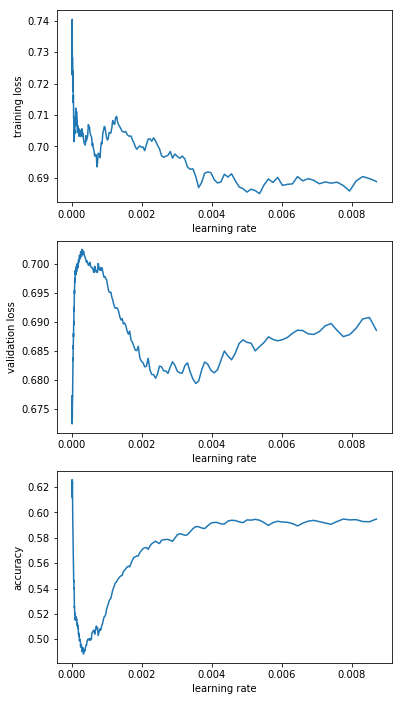

In [68]:
learn.lr_find2(start_lr=1e-5,end_lr=1e-2, num_it=300)
learn.sched.plot()

In [303]:
learn.fit(lrs, 1, wds=wd, cycle_len=1, use_clr_beta=(32,10,0.8,0.7))

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                  
    0      0.651956   0.602512   0.647467  


[array([0.60251]), 0.6474673204562243]

In [304]:
learn.save('clas2_0')

In [305]:
learn.load('clas2_0')

In [306]:
learn.freeze_to(-2)

In [307]:
learn.fit(lrs, 1, wds=wd, cycle_len=1, use_clr_beta=(32,10,0.8,0.7))

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                  
    0      0.584535   0.559963   0.679943  


[array([0.55996]), 0.6799428042243508]

In [308]:
learn.save('clas2_1')

In [309]:
learn.load('clas2_1')

In [310]:
learn.unfreeze()

In [311]:
learn.fit(lrs, 1, cycle_len=20, use_clr_beta=(32,10,0.8,0.7), best_save_name='clas2')

HBox(children=(IntProgress(value=0, description='Epoch', max=20), HTML(value='')))

 32%|███▏      | 17/53 [00:01<00:02, 13.31it/s, loss=0.558]

Exception in thread Thread-67:
Traceback (most recent call last):
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



epoch      trn_loss   val_loss   accuracy                  
    0      0.569522   0.557842   0.687908  
    1      0.586389   0.555611   0.708946                  
    2      0.581056   0.552031   0.698734                  
    3      0.573087   0.538035   0.703636                  
    4      0.556313   0.542276   0.733047                  
    5      0.582528   0.534798   0.725286                  
    6      0.569226   0.542776   0.709763                  
    7      0.567785   0.55161    0.691176                  
    8      0.536791   0.53412    0.701185                  
    9      0.520754   0.531068   0.716708                  
    10     0.542675   0.541009   0.70241                   
    11     0.514936   0.517249   0.722631                  
    12     0.498606   0.544956   0.722426                  
    13     0.486585   0.526943   0.722426                  
    14     0.474307   0.548925   0.722631                  
    15     0.481964   0.543068   0.719159               

[array([0.53832]), 0.7152777840109432]

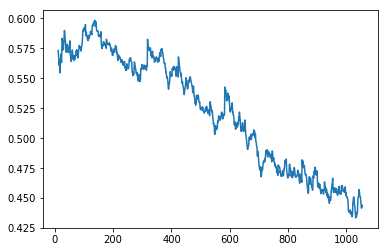

In [312]:
learn.sched.plot_loss()

## Check F1 score

We load the model with the corresponding weights and parameters

In [313]:
learn = RNN_Learner(md, TextModel(to_gpu(m)), opt_fn=opt_fn)
learn.reg_fn = partial(seq2seq_reg, alpha=2, beta=1)
learn.clip=.12
learn.metrics = [accuracy]

We perform predictions on each of the val_sets texts as per Matthias Bachfischer's script in https://github.com/Bachfischer/german2vec/blob/master/src/sb-10k-use_pretrained_language_model.ipynb

In [314]:
# load test set tokens
tok_val = np.load(CLAS_PATH/'tmp'/'tok_val.npy')

# load classification model weights
learn.load('clas2')
m = learn.model

# set batch size to 1
m[0].bs=1

i = 0
results = []
while i < len(tok_val):
    sen = ' '.join(tok_val[i])
    i+=1
    m.eval()
    # reset hidden state
    m.reset()
    idxs = np.array([[stoi[p] for p in sen.strip().split(" ")]])
    idxs = np.transpose(idxs)
    # get predictions from model
    p = m(VV(idxs))
    print(sen + ': ' + str(to_np(torch.topk(p[0],1)[1])[0]))
    # append classification to list of results for validation
    results.append(torch.topk(p[0],1)[1].data.tolist()[0])


 xbos t_up esp josé luis ábalos : " rajoy tendrá que convocar elecciones si no sale de la parálisis ": [1]

 xbos t_up ven maduro quiere enfrentarse a ramos allup en las elecciones presidenciales: [1]

 xbos t_up usa obispo de la diócesis de chilpancingo - chilapa pide dialogar con el crimen organizado: [1]

 xbos t_up esp la inteligencia de ee uu alerta del riesgo de injerencia rusa en las legislativas de noviembre y en europa: [1]

 xbos t_up esp las denuncias a menores por violencia machista se triplican: [1]

 xbos t_up mex vecinos denuncia maltrato animal en supuesta pensión de la merced gómez: [1]

 xbos t_up col ' ante corrupción , la corte se autocriticó y renovó ' : hernández: [1]

 xbos t_up mex aparece con vida el periodista mario cañas: [0]

 xbos t_up usa se separaron jennifer aniston y justin theroux , tras dos años y medio de matrimonio: [1]

 xbos t_up usa la t_up anmat prohibió la comercialización de productos médicos y alimenticios: [0]

 xbos t_up col murió el princ


 xbos t_up usa frente amplio venezuela libre realiza presentación de nueva plataforma unitaria ( + manifiesto ): [1]

 xbos t_up cub evalúan descargos de aspirantes a fiscal general en guatemala: [1]

 xbos t_up usa 10 int_string datos sobre la famosa marmota chuck: [0]

 xbos t_up chi la pareja de ricardo palma salamanca fue detenida en francia: [1]

 xbos t_up col israel redobla las advertencias a irán tras los ataques en siria: [1]

 xbos t_up usa por escasez de focas , muere 40 % de los osos polares: [1]

 xbos t_up mex marco antonio sánchez “ tiene actitud del demonio ” , dice su madre: [1]

 xbos t_up ven el otro fidel castro: [0]

 xbos t_up per expolicía fue capturado con 175 int_string kilos de cocaína: [1]

 xbos t_up ven dos personas mueren por disparos en el campus de una universidad de ee uu: [1]

 xbos t_up col el pulso electoral en la frontera caliente: [1]

 xbos t_up per san miguel : arqueólogos encuentran restos humanos de 1.300 años en huaca el rosal: [1]

 xbos t_u


 xbos t_up arg hallan muerto a gabriel cruz , el chico desaparecido en españa: [1]

 xbos t_up esp la web y la app de t_up ing direct se caen durante más de tres horas: [1]

 xbos t_up mex guajardo : supeditar aranceles al t_up tlc , no: [1]

 xbos t_up chi cuestionado jefe técnico de centro de coronel fue removido del sename: [1]

 xbos t_up mex joven mata a sus padres y hiere a su hermano en guanajuato: [1]

 xbos t_up arg el otro fidel castro: [0]

 xbos t_up arg de vido se libró de un procesamiento por los subsidios: [1]

 xbos t_up chi atentado incendiario destruye 4 int_string camiones y 3 int_string retroexcavadoras en contulmo: [1]

 xbos t_up esp ricky también escarba en el abismo de los grizzlies : ¡ 16 derrotas consecutivas !: [1]

 xbos t_up chi transantiago : alza de tarifa aportará us$ 30 int_string millones al sistema y piden nuevo incremento del subsidio: [1]

 xbos t_up per andahuaylas : capturan a violador incluido en lista de más buscados: [1]

 xbos t_up col candid

In [315]:
preds = np.asarray(results)

In [316]:
from sklearn.metrics import *
# f1 score for all three classes
f1_score(val_labels, preds, average='macro')

0.6656683807048276